In [1]:
# General libraries
import sys
import os
import platform
import glob
import pathlib
import time
import math
import zipfile
import math
import random
from random import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from tqdm.notebook import trange, tqdm
from IPython.display import FileLink
from termcolor import colored
from rich.progress import Progress

import matplotlib

### Import Maxpro tools

First, try to build the Cython version. This translates the `.pyx` file into C code and then compiles it into a shared library (a dynamic link library on Windows, or a `.so` file on Linux/macOS). This shared library can then be imported and executed from Python.

Try to import either the Cython version (more optimized; requires building) or the pure Python (NumPy-based) version as a fallback.

In [2]:
!{sys.executable} setup.py build_ext --inplace

running build_ext
copying build\lib.win-amd64-cpython-312\MaxproTools_cython.cp312-win_amd64.pyd -> 


In [3]:
try:
    #import dynamic libraries built from MaxproTools_cython.pyx
    #raise Error("hi, im an error")
    from MaxproTools_cython import maxPro_c as maxPro
    from MaxproTools_cython import delta_c as delta
    print('Using Cython versions of functions.')
except:
    from MaxproTools_python import maxPro_np as maxPro
    from MaxproTools_python import delta_np as delta
    print('''Using Python versions of functions. To use faster Cython version
          the code has to be build using: python setup.py build_ext --inplace.''')

Using Cython versions of functions.


In [4]:
# Python files
from GenerateMaxProDesign import (
    generate_design,     # Optimizing one design (annealing)
    get_tskname_dirname, # Constructing task/dir names
    get_LHS_design       # Generating initial LHS design
)
from plotting import *

## Matplotlib setup

In [5]:
# Setup LaTeX
try:
    setup_latex()
except:
    print("Couldn't setup Matplotlib for LaTeX")

# Choose backend
try:
    %matplotlib widget
    print("Using widget")
except:
    %matplotlib qt5agg
    print("Using qt5agg")

Using widget


## Set the dimension and sample size and test parameters of the simulated annealing optimization

In [24]:
nv = 2          # number of dimensions (factors)
ns = 25         # number of points (sample size)
periodic = False # False <=> standard MaxPro (Joseph, Gul, and Ba, Biometrika 2015), True <=> uMaxPro (Vorechovsky and Masek 2025)
n_des = 1       # number of testing designs

# simulated annealing
ntrials = 200000 #simulated annealing trials
nhungry = 10000 #hungry algorithm trials


# Select the method for constructing the initial design to be optimized by coordinate swaps
#x_ini = np.random.rand(ns, nv)   # random coordinates with random ordering
#x_ini = get_LHS_design(ns, nv)   # LHS-median coordinates with random ordering
x_ini = get_LHS_design(ns, nv)    # Latizined Sobol sequence

x_wrk = x_ini.copy() # working design (undergoes random coordinate swaps)
x_opt = x_ini.copy() # final (optimized) design

# working arrays for array versions
row_sum  = np.zeros(ns)       #arrays with numpy
inv_prod = np.zeros((ns,ns))
row1     = np.zeros(ns)
row2     = np.zeros(ns)
new_sums = np.zeros(ns)

old1 = np.zeros(ns) #row vector for pt1 (old)
old2 = np.zeros(ns) #row vector for pt2 (old)
new1 = np.zeros(ns) #row vector for pt1 (new)
new2 = np.zeros(ns) #row vector for pt2 (new)

# history tracking
T_hist = np.zeros(ntrials+nhungry) # history of temperature
maxpro_hist = np.zeros(ntrials+nhungry) # history of temperature
maxpro_opt_hist = np.zeros(ntrials+nhungry)


# construct the task name and the directory path
tsk_name, dir_name = get_tskname_dirname(nv, ns, periodic, n_des)

dirname = pathlib.Path(dir_name)
if not dirname.exists():
    dirname.mkdir(parents=True, exist_ok=True)
    print("New directory created:", dir_name)



maxpro = maxPro(x_wrk,ns,nv,periodic) # evaluate the criterion
maxpro_ini = maxpro
maxpro_opt = maxpro


# perform estimation of the absolute changes in the criterion value 
# induced by random swaps
ave_abs_delta = 0
ntest = 1000
for trial in trange (ntest):
    var_i,var_j = np.random.choice(ns, size=2, replace=False) #select two different points for swap
    v = np.random.randint(nv, size=1)[0] #select a dimension for swap
    ave_abs_delta += np.abs( delta(x_wrk, ns, nv, var_i, var_j, v, periodic) )
ave_abs_delta /= ntest

print(f"average absolute delta: {ave_abs_delta:.4g}")
    

# Set the initial temperature, the final temperature and the reduction factor in each trial

T_ini = ave_abs_delta*1 # set the initial temparature to a multiple of the average change in the criterion value
T_end = T_ini / 1e3
T_fact = (T_end / T_ini)**(1/ntrials)


#improvefact = 0.00001 #expected improvement by optimization
#T_fact = (improvefact)**(1/ntrials) #factor decreasing temperature in each trial
#T_end = T_ini * T_fact**ntrials

print(f"init temperature: {T_ini:.4g}, final temperature: {T_end:.4g}, reduction factor: {T_fact:.8g}")

  0%|          | 0/1000 [00:00<?, ?it/s]

average absolute delta: 2.252e+05
init temperature: 2.252e+05, final temperature: 225.2, reduction factor: 0.99996546


In [25]:
%%time
# Perform the optimization of the testing design
des = 0
seed = 0

task_args = nv, ns, periodic, ntrials, nhungry, T_ini, T_fact, tsk_name, dir_name, des, seed

#generate one design to see the simulated annealing progess (parameter setting)
x_opt, x_ini, crit, T_hist, maxpro_hist, maxpro_opt_hist = generate_design(*task_args)

print(f"MaxPro criterion values:")
print(f"initial design   {maxPro(x_ini, ns, nv, periodic ):.4g}")
print(f"optimized design {maxPro(x_opt, ns, nv, periodic ):.4g}")

MaxPro criterion values:
initial design   2.427e+06
optimized design 3.622e+05
CPU times: total: 3.17 s
Wall time: 3.21 s


In [26]:
if platform.system() in ["Linux", "Darwin"]:
    os.system(f"chmod 777 -R {dir_name}")  # modify the rights on Linux/macOS
else:
    print("Skipping chmod command: not running on Linux/macOS.")
    
dir_name

Skipping chmod command: not running on Linux/macOS.


'data\\nv=0002_ns=00025_per=False_ndes=000001'

## Plot the history of (u)MaxPro criterion and temperature as a function of trials

D:\Downloads\MirekFromScratch2\SimulatedAnnealingProgress.pdf

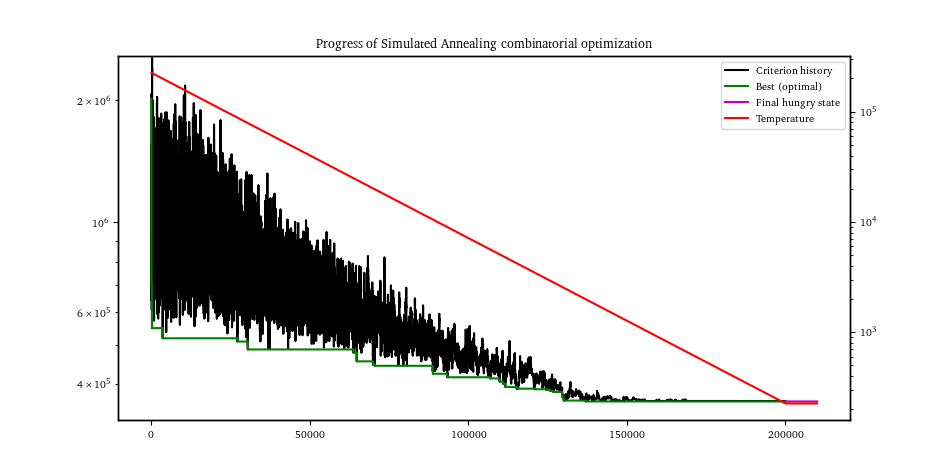

In [27]:
fig_hist, ax_hist = plt.subplots(nrows=1, ncols=1, figsize = (24/2.54,12/2.54))
plot_progress(ax_hist, ntrials, nhungry, maxpro_hist, maxpro_opt_hist, T_hist )

## Plot the 2D view of the design with periodic extension

D:\Downloads\MirekFromScratch2\2D_view_comparison.pdf

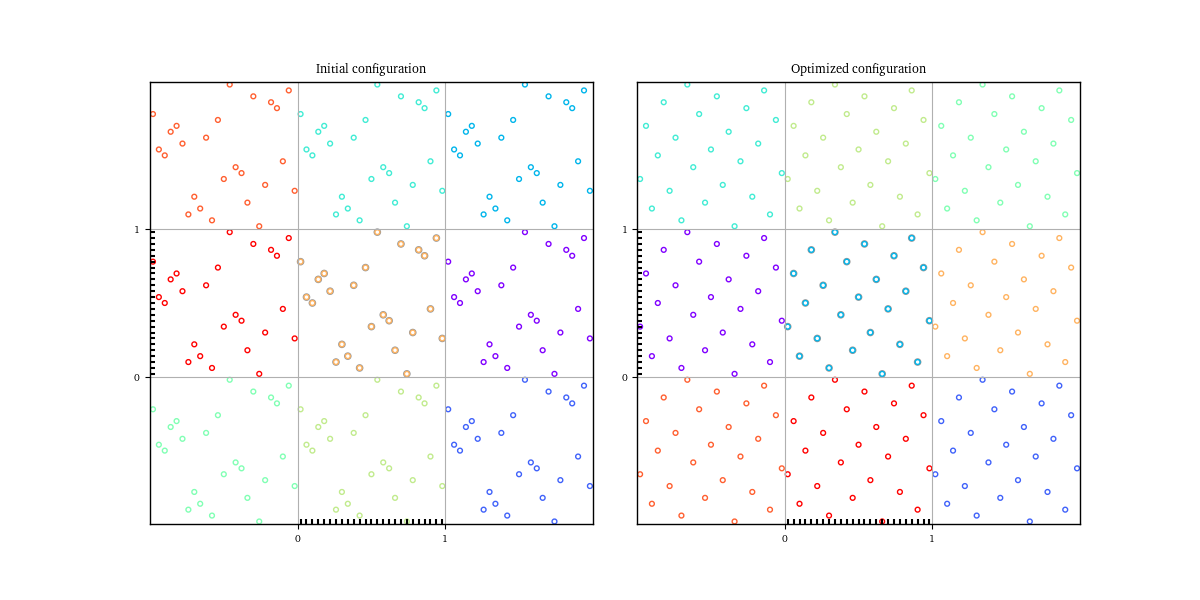

In [28]:
vars_to_plot=[0, 1] # select the two dimensions to be plotted
plot_2D_view_comparison(nv, ns, x_ini, x_opt, vars_to_plot)

# Generate a set of optimized designs

In [29]:
# prepare the pool generating 'n_des' designs.

n_des = 150
task_args = nv, ns, periodic, ntrials, nhungry, T_ini, T_fact, n_des
task_args = ' '.join( [str(i) for i in task_args ] )
task_args #check the line sent to the generator

'2 25 False 200000 10000 225197.13993209953 0.9999654618200617 150'

In [30]:
# start the pool generating 'n_des' designs. 
# starts in bash/command line
# ipython version of the call
!{sys.executable} GenerateMaxProDesign.py {task_args} 
#os.system(f'python GenerateMaxProDesign.py {task_args}') # python version  of the call

# testing call
#!python GenerateMaxProDesign.py 2 13 True 100 1000 12354566.123 0.6555 13

['2', '25', 'False', '200000', '10000', '225197.13993209953', '0.9999654618200617', '150']
Task settings: 2 25 200000 10000 225197.13993209953 0.9999654618200617 nv=0002_ns=00025_per=False_ndes=000150 data\nv=0002_ns=00025_per=False_ndes=000150
pool apply complete
joining pool processes
join complete
the end


In [31]:
tsk_name, dir_name = get_tskname_dirname(nv, ns, periodic, n_des)
tsk_name, dir_name

('nv=0002_ns=00025_per=False_ndes=000150',
 'data\\nv=0002_ns=00025_per=False_ndes=000150')

In [32]:
if platform.system() in ["Linux", "Darwin"]:
    os.system(f"chmod 777 -R {dir_name}")  # modify the rights on Linux/macOS
else:
    print("Skipping chmod command: not running on Linux/macOS.")

Skipping chmod command: not running on Linux/macOS.


## Pack all generated designs into a single npy file `x_opt_all`

In [33]:
%%time
# accessing and printing files in directory and subdirectory
#task_name = 'nv=0002_ns=00012_per=False_ndes=020000'
#dir_name = os.path.join('data', task_name)
zip_fname = os.path.join(dir_name, tsk_name + '.zip')

x_opt_all_fname = os.path.join(dir_name, tsk_name + '-x_opt_all.npy') # construct filename
if not os.path.exists(x_opt_all_fname):
    x_opt_all = [] #create list for opened designs
    zf = zipfile.ZipFile(zip_fname, 'w', zipfile.ZIP_DEFLATED)
    npy_list = glob.glob(dir_name + '/*[0-9][0-9][0-9][0-9][0-9][0-9].npy', recursive=False)
    npy_list.sort()
    for des_fname in npy_list:
        des_basename = os.path.basename(des_fname) #take only the name of file, not the whole path
        x_opt_all.append(np.load(des_fname))
        
        zf.write(os.path.join(dir_name, des_basename), # zapisovany soubor
                 os.path.join(tsk_name, des_basename)) # cesta uvnitr archivu
        
    zf.close()

    x_opt_all = np.array(x_opt_all)
    np.save(x_opt_all_fname, x_opt_all) #save all designs into a single npy file. the first dimension indexes the design
    for des_fname in npy_list: # Delete all individual designs (as they are now in the .zip)
        os.remove(des_fname)
else:
    x_opt_all = np.load(x_opt_all_fname)

CPU times: total: 0 ns
Wall time: 958 μs


## Plot the histogram of achieved values of (u)MaxPro criterion

353731.7304462932 387371.16121115524 0.9131596924776616


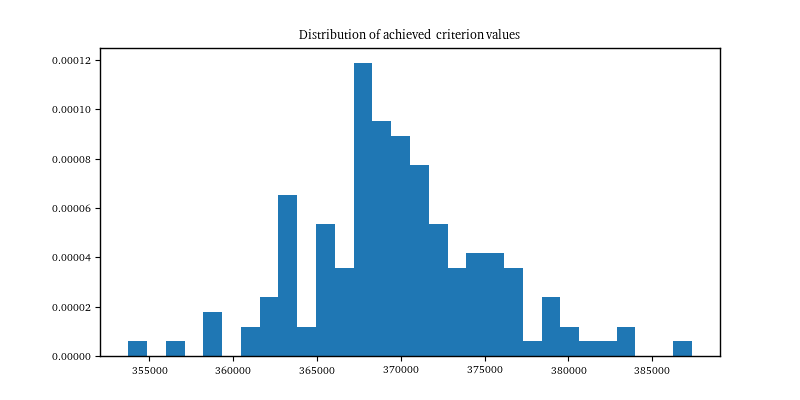

In [34]:
n_des = x_opt_all.shape[0] #number of designes packed into x_opt_all
maxpros = np.empty(n_des)

for i in range(n_des): #compute the values of the criterion
    maxpros[i] =  maxPro( x_opt_all[i,:,:] , ns, nv, periodic )


fig_hist_maxpro, ax = plt.subplots(nrows=1, ncols=1, figsize = (8,4) )
ax.set_title('Distribution of achieved criterion values')

kk = plt.hist(maxpros, bins=30, density=True)

maxpros_fname = os.path.join(dir_name, tsk_name + '-MaxPros.npy') # construct filename
np.save(maxpros_fname, maxpros)

print(maxpros.min(), maxpros.max(), maxpros.min()/maxpros.max())

# Compute frequencies of bin occupancy from all designs (histogram)


## Optionally generate virtual designs by mirroring and reordering axes [`symmetrize = True`]

The following code virtually increases the number of generated designs $2^{n_v} n_v!$ times by mirroring each about every axis and re-ordering the axes. Note that this may not always be wanted, as it artificially adds symmetry to the empirical histogram. It may not be clear why this works as it is highly optimized, the following lines will explain so.

The time complexity of python execution is $\Theta\left(n_v^2\right)$ and $\Theta\left(n_s^{n_v} n_v^2\right)$ of the *full* numpy excution.

First, instead of doing the calculations on every single design, lets make a histogram of the designs unmodified (saved as `frequencies`; not normalized). Doing then the operations on these sums is way more efficient.

### Reordering axes

Have a function $p_v(H)$, that takes a histogram $H$, considers all permutations of axes $v$ and higher (have axes be numbered from 1), and adds all such histograms up. So what we want now is to define $p_1$ efficiently.

$p_{n_v}(H)$ is simple. It returns $H$, there are no other possible permutations of one axis. $p_{n_v - 1}(H)$ is as fast as it gets. It adds the original $H$ and a $H$ with the last two axes swapped. For clarity, we could put each of the two through $p_{n_v}$. Notice, though, that $p_{n_v - 1}$ only ever defines each number of the output histogram as a sum of certain values of the input. Thus, for histograms $H$ and $G$, $p_{n_v - 1}(H) + p_{n_v - 1}(G) = p_{n_v - 1}(H + G)$.

This gives an advantage when defining $p_{n_v - 2}(H)$. Instead of placing every of the last three axes on the position of the third-from-end position and then running the results separately through $p_{n_v - 1}$ (so that it considers the permutations of the remaining two axes), we can sum these three versions of $H$ up and *then* run them through $p_{n_v - 1}$. Thinking it through once again, $p_{n_v - 2}(H) + p_{n_v - 2}(G) = p_{n_v - 2}(H + G)$ (for any histograms $H$ and $G$).

We could continue on all the way to $p_1(H)$ and see, that it only considers all the $n_v$ axes to be put on the first place, adds these versions of $H$ up and sends it to $p_2$. That, once again, considers all the $n_v - 1$ axes of the modified histogram to be put on the second place, adds all of them up and sends the result to $p_3$...

### Mirroring

Rather than mirroring already while the axes are reordered, we can simply take the histogram of designs only modified by axis reordering and consider all the mirrored versions of these (adding them all up).

Also, there is no need for going through all the $2^{n_v}$ combinations of which subset of axes is mirrored. We can just mirror it about the first axis, add the original and the mirrored together into $H_1$. Then, for all the combinations of the first two axis, we only have to mirror $H_1$ about the second axis and add *these* to up...

In [35]:
def calculate_box_numbers(x_opt, ns, nv):
    """Vectorized calculation of unique box numbers for points in x_opt"""
    # Compute indices for each dimension
    indices = np.floor(x_opt * ns).astype(int)
    # Calculate box numbers using base-ns representation
    base_ns = np.power(ns, np.arange(nv))
    box_numbers = np.dot(indices, base_ns)
    return box_numbers #vraci pro kazdy bod cislo policka v histogramu o delce = pocet radku x_opt (ns numbers)

def update_frequencies(x_opt, frequencies, ns, nv) -> None:
    box_numbers = calculate_box_numbers(x_opt, ns, nv)
    # box_numbers are indices into the flattened histogram (frequencies)
    np.add.at(frequencies, box_numbers, 1)
    
def update_frequencies_shaped(x_opt, frequencies_shaped, ns, nv) -> None:
    box_numbers = np.floor(x_opt * ns).astype(int) #transorm coords into indices
    print(frequencies_shaped[tuple(box_numbers.T)].shape)
    frequencies_shaped[tuple(box_numbers.T)] += 1

In [36]:
symmetrize = True # to generate the additional designs from the existing ones

n_des = x_opt_all.shape[0] #number of designes packed into x_opt_all

# Histogram of unmodified designs
print("Building unmodified designs histogram...")
freq = np.zeros(ns ** nv, dtype=int) # Flattened for now -- indexing is faster (no need for conversion to tuple)
for i in trange(n_des):
    update_frequencies(x_opt_all[i], freq, ns, nv)
freq.shape = [ns for _ in range(nv)]
print("Done")

print(f"Check that the no of data in bins {np.sum(freq)} matches the number of points {n_des*ns}")

design_count_multiplier = 1
freq_s = freq.copy() # Stands for frequencies symmetrized (identical to `freq` if not symmetrizing)
if symmetrize:
    # Account for reordering the axes
    print("Reordering axes...")
    for set_v in trange(nv - 1): # Note that this trange is going to speed up over time
        freq_copy = np.copy(freq_s) # Add to the `freq_s` array; this is for a reference to get all the distinct transposed versions of the original
        transpose_indices = [i for i in range(nv)]
        for swapped_v in range(set_v + 1, nv): # You would normally go from `set_v` + 0, but I am adding to an array equivalent to `swapped_v` = `set_v`
            transpose_indices[set_v] = swapped_v
            transpose_indices[swapped_v] = set_v
            freq_s += np.transpose(freq_copy, tuple(transpose_indices))
            transpose_indices[swapped_v] = swapped_v # Cleanup for next loop run
    print("Done")
    
    # Mirror about every axis
    print("Mirroring...")
    for v in trange(nv):
        freq_s += np.flip(freq_s, axis=v)
    print("Done")
    
    design_count_multiplier = (2 ** nv) * math.factorial(nv)
    print("Design count incerased ", design_count_multiplier," times from ",n_des, " to ", n_des * design_count_multiplier)
    
    print(f"Check that the no of data in bins {np.sum(freq_s)} matches the number of points {n_des*ns*design_count_multiplier}")

# Recompute frequencies into relative freq (ave density)
histogram = freq * ((ns ** (nv-1)) / n_des)
histogram_s = freq_s * ((ns ** (nv-1)) / n_des / design_count_multiplier)

print(f"\n")
print(f"Minimum density: {histogram.min()},  maximum density: {histogram.max()}, stdev of density: {histogram.std()}")

Building unmodified designs histogram...


  0%|          | 0/150 [00:00<?, ?it/s]

Done
Check that the no of data in bins 3750 matches the number of points 3750
Reordering axes...


  0%|          | 0/1 [00:00<?, ?it/s]

Done
Mirroring...


  0%|          | 0/2 [00:00<?, ?it/s]

Done
Design count incerased  8  times from  150  to  1200
Check that the no of data in bins 30000 matches the number of points 30000


Minimum density: 0.0,  maximum density: 4.0, stdev of density: 0.7281635957820345


# Create histogram

Looks best when $2 \mid n_v$. Otherwise only looks decent when $n_s$ is a square of an integer.

  0%|          | 0/1 [00:00<?, ?it/s]

D:\Downloads\MirekFromScratch2\data\nv=0002_ns=00025_per=False_ndes=000150\nv=0002_ns=00025_per=False_ndes=000150_non-symmetrized_hist.pdf

D:\Downloads\MirekFromScratch2\data\nv=0002_ns=00025_per=False_ndes=000150\nv=0002_ns=00025_per=False_ndes=000150_non-symmetrized_hist_colorbar.pdf

  0%|          | 0/1 [00:00<?, ?it/s]

D:\Downloads\MirekFromScratch2\data\nv=0002_ns=00025_per=False_ndes=000150\nv=0002_ns=00025_per=False_ndes=000150_symmetrized_hist.pdf

D:\Downloads\MirekFromScratch2\data\nv=0002_ns=00025_per=False_ndes=000150\nv=0002_ns=00025_per=False_ndes=000150_symmetrized_hist_colorbar.pdf

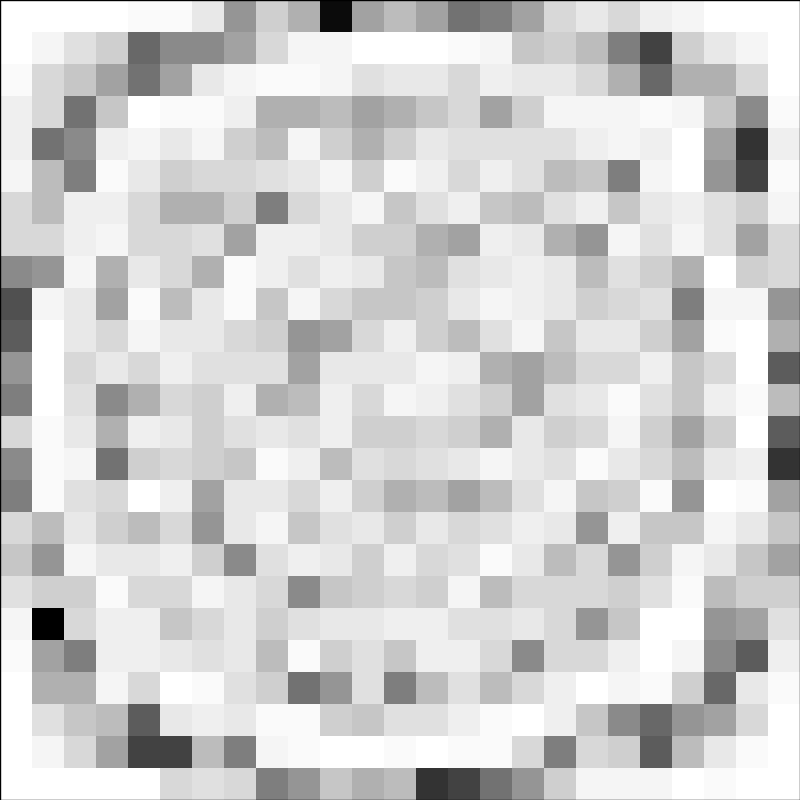

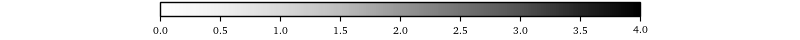

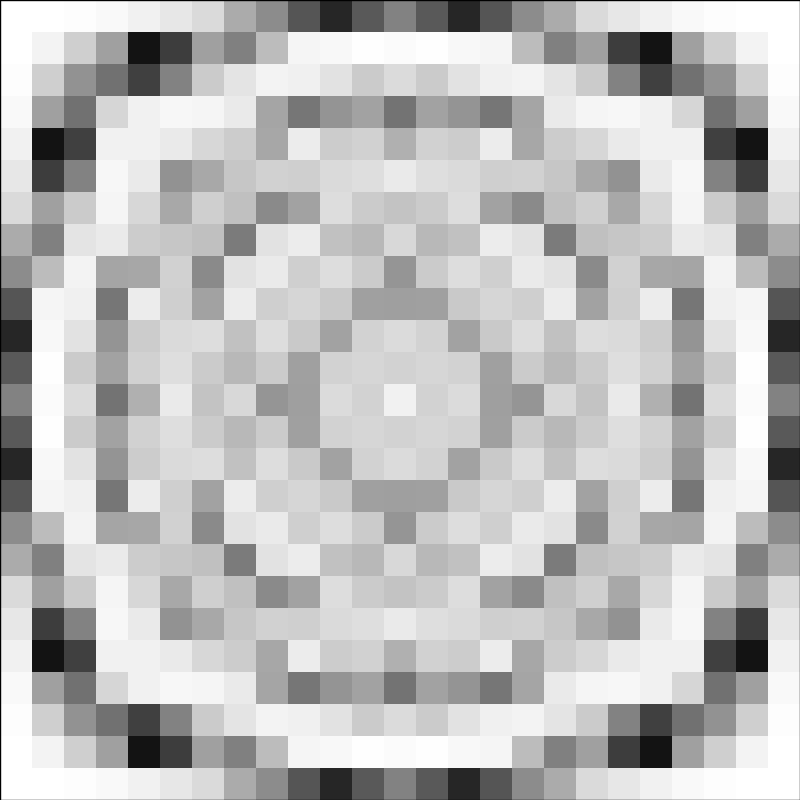

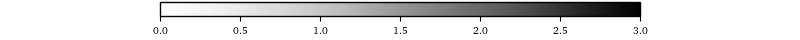

In [37]:
plot_histogram(histogram, ns, nv, tsk_name + "_non-symmetrized", dir_name)
plot_histogram(histogram_s, ns, nv, tsk_name + "_symmetrized", dir_name)

## Visually check the designs one by one

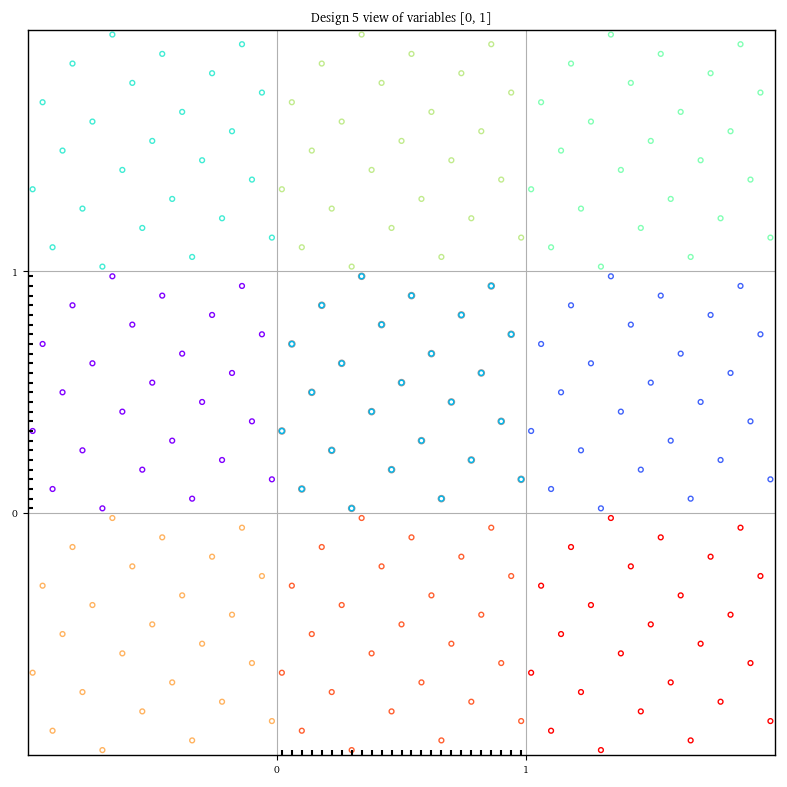

In [42]:
des += 1 # each run of the cell increases the design index by one
vars_to_plot=[0,1] #select the variables (factors) to plot
x_opt = x_opt_all[des]

fig, ax_opt = plt.subplots(nrows=1, ncols=1,  figsize = (20/2.54,20/2.54), 
                                                tight_layout = True, sharey = True)
plot_2D_view(nv, ns, x_opt, ax_opt, vars_to_plot, des)
